<a href="https://colab.research.google.com/github/kulaginv/cvr_course/blob/main/notebooks/nn_sem5_pt2_hw5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import math
import random

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

In [2]:
device=torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Domik Dataset

In [3]:
class DomikDataset(Dataset):
    def __init__(self, dataset_size, noise=0.0):
        super().__init__()
        self.house_width = 0.6
        self.house_height = 0.7
        self.roof_height = 0.3
        
        self.points, self.targets = self._generate(dataset_size, noise)

    def _left_roof(self, point):
        b = (0.5 * self.house_height - (self.house_height + self.roof_height) * (1 - self.house_width) / 2) / \
            (0.5 - (1 - self.house_width) / 2)
        k =  2 * (self.house_height - b) / (1 - self.house_width)
        return k * point[0] + b >= point[1]

    def _right_roof(self, point):
        b = (0.5 * self.house_height - (self.house_height + self.roof_height) * (1 + self.house_width) / 2) / \
            (0.5 - (1 + self.house_width) / 2)
        k = 2 * (self.house_height - b) / (1 + self.house_width)
        return k * point[0] + b >= point[1]
    
    
    def _generate(self, size, noise):
        points = [[random.random(), random.random()] for i in range(size)]

        targets = []
        for point in points:
            if (1 - self.house_width) / 2 <= point[0] <= (1 + self.house_width) / 2 and \
                self._left_roof(point) and self._right_roof(point):   
                inside = 1.
            else:
                inside = 0.

            if random.random() < noise:
                inside = 1. - inside

            targets.append(torch.tensor([inside], device=device))

        return points, targets
    
    def show(self, dividing_criterion=lambda s: 1 if s > 0.5 else 0):
        domik_x = []
        domik_y = []
        nedomik_x = []
        nedomik_y = []

        for sample in self:
            point, target = sample
            if dividing_criterion(target):
                domik_x.append(point[0])
                domik_y.append(point[1])
            else: 
                nedomik_x.append(point[0])
                nedomik_y.append(point[1])

        plt.plot(domik_x, domik_y, '.', nedomik_x, nedomik_y,'.')

    def __len__(self):
        return len(self.points)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
               
        sample = (torch.tensor(self.points[idx], device=device), self.targets[idx])

        return sample

# Train function

In [4]:
def train(network, train_dataset, epochs, criterion, optimizer):
    loss_epochs = []
    for idx in range(epochs):
        loss_samples = []
        for sample in train_dataset:
            optimizer.zero_grad()   # zero the gradient buffers
            point, target = sample
            output = network(point)
            loss = criterion(output, target.to(device))
            loss.backward()
            loss_samples.append(loss.data.numpy())
            optimizer.step()    # Does the update

        loss_samples_mean = float(sum(loss_samples)) / len (loss_samples)
        print(f"Epoch {idx: >8} Loss: {loss_samples_mean}")
        loss_epochs.append(loss_samples_mean)

    plt.plot(loss_epochs)
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.show() 

# Test function

In [5]:
def test(network, test_dataset, dividing_criterion):
    domik_x = []
    domik_y = []
    nedomik_x = []
    nedomik_y = []

    correct = 0
    total = 0

    with torch.no_grad():
        for sample in test_dataset:
            inp, target = sample
            output = network(inp)
            total += 1
            correct += (dividing_criterion(output) == dividing_criterion(target))

            # dividing dataset for plotting
            if dividing_criterion(output):
                
                domik_x.append(inp[0])
                domik_y.append(inp[1])
            else: 
                nedomik_x.append(inp[0])
                nedomik_y.append(inp[1])
    
    plt.figure(figsize=(20,5))
    plt.subplot(121)
    test_dataset.show()
    plt.subplot(122)
    plt.plot(domik_x, domik_y, '.', nedomik_x, nedomik_y, '.')

    print(f'Accuracy of the network on the {total} test samples: {100 * correct / total}')

# First steps

## Dataset

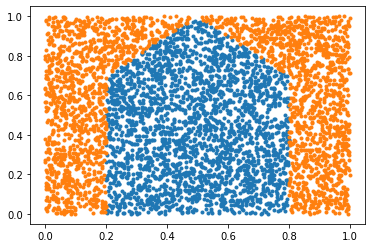

In [6]:
DATASET_SIZE = 5000
domik = DomikDataset(DATASET_SIZE)

data = DataLoader(domik, batch_size=1)

# plotting
domik.show()

## Net

In [ ]:
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(2, 1)

    def forward(self, x):
        x = F.sigmoid(self.fc1(x))
        return x

net = Net().float().to(device)
print(net)

In [9]:
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(2, 40)
        self.fc2 = nn.Linear(40, 1)

    def forward(self, x):
        x = F.leaky_relu(self.fc1(x))
        x = F.leaky_relu(self.fc2(x))
        return x

net = Net().float().to(device)
print(net)

Net(
  (fc1): Linear(in_features=2, out_features=40, bias=True)
  (fc2): Linear(in_features=40, out_features=1, bias=True)
)


## Train

Epoch        0 Loss: 0.012925656910600415
Epoch        1 Loss: 0.01236098444235217
Epoch        2 Loss: 0.012082547332148115
Epoch        3 Loss: 0.011853690910661805
Epoch        4 Loss: 0.01166451025829148
Epoch        5 Loss: 0.011474255454540198
Epoch        6 Loss: 0.011322622136494891
Epoch        7 Loss: 0.011181878160909446
Epoch        8 Loss: 0.011050313651635852
Epoch        9 Loss: 0.010937829370439578
Epoch       10 Loss: 0.010849117248595675
Epoch       11 Loss: 0.010754880942521533
Epoch       12 Loss: 0.010677617234346057
Epoch       13 Loss: 0.010569298689324116
Epoch       14 Loss: 0.01046907596963806
Epoch       15 Loss: 0.01040243382647731
Epoch       16 Loss: 0.010323649710060626
Epoch       17 Loss: 0.010261827617645394
Epoch       18 Loss: 0.010218058113226642
Epoch       19 Loss: 0.010163622687614093


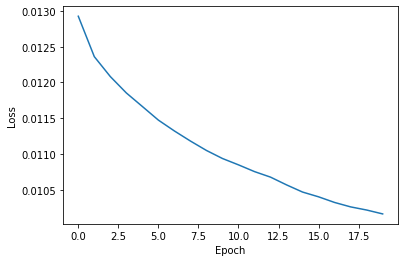

In [12]:
EPOCHS_TO_TRAIN = 20
train(network=net, 
      train_dataset=domik, 
      epochs=EPOCHS_TO_TRAIN, 
      criterion=nn.MSELoss(), 
      optimizer=optim.SGD(net.parameters(), lr=0.01))

25 эпох 0.1  
20 эпох 0.01

## Test

Accuracy of the network on the 25000 test samples: 99.412


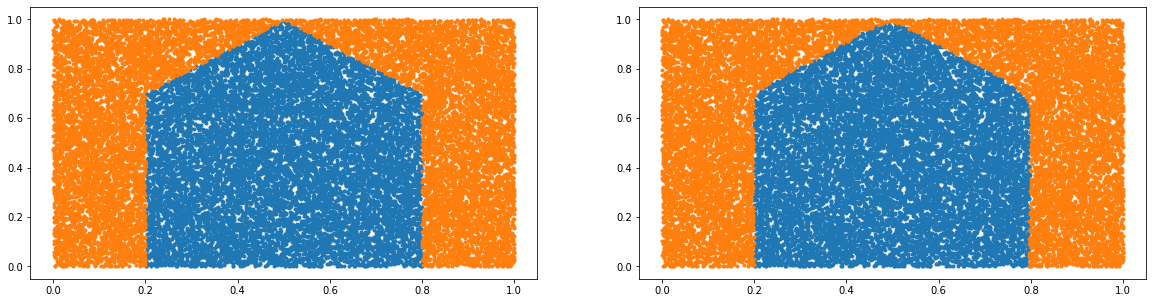

In [13]:
test_dataset = DomikDataset(DATASET_SIZE*5)
test(network=net, test_dataset=test_dataset, dividing_criterion=lambda s: 1 if s > 0.5 else 0)

# Domik dataset for multi classes

In [14]:
class MultiClassDomikDataset(DomikDataset):
    def __init__(self, dataset_size, noise=0.0):
        super().__init__(dataset_size, noise)
        
    def show(self, dividing_criterion=lambda s: s[0] > s[1]):
        #super().show(dividing_criterion)
        super().show()
        
    def _generate(self, size, noise):
        points, targets = super()._generate(size, noise)
        for i, target in enumerate(targets):
            targets[i] = int(targets[i].item())
        return points, targets

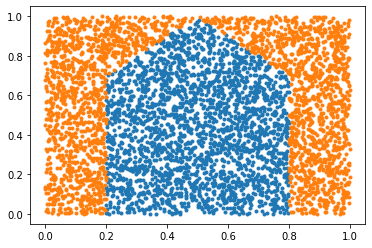

In [15]:
DATASET_SIZE = 5000
domik = MultiClassDomikDataset(DATASET_SIZE)

data = DataLoader(domik, batch_size=3)

# plotting
domik.show()

## Net

In [16]:
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(2, 40)
        self.fc2 = nn.Linear(40, 2)

    def forward(self, x):
        x = F.leaky_relu(self.fc1(x))
        x = F.leaky_relu(self.fc2(x))
        return x

net = Net().float().to(device)
print(net)

Net(
  (fc1): Linear(in_features=2, out_features=40, bias=True)
  (fc2): Linear(in_features=40, out_features=2, bias=True)
)


## Train

Epoch        0 Loss: 0.037038344371903766
Epoch        1 Loss: 0.03577518550054704
Epoch        2 Loss: 0.0355133419857326
Epoch        3 Loss: 0.03527921066696002
Epoch        4 Loss: 0.035067947179229106
Epoch        5 Loss: 0.03486505924020759
Epoch        6 Loss: 0.034691648643539644
Epoch        7 Loss: 0.034527476992101895
Epoch        8 Loss: 0.03436761139624806
Epoch        9 Loss: 0.034227742844577566
Epoch       10 Loss: 0.034071669465815
Epoch       11 Loss: 0.033919849063598566
Epoch       12 Loss: 0.0337835514458316
Epoch       13 Loss: 0.03364526975064838
Epoch       14 Loss: 0.033486812031503596
Epoch       15 Loss: 0.03332664888263106
Epoch       16 Loss: 0.03317888520457771
Epoch       17 Loss: 0.033027978224066286
Epoch       18 Loss: 0.03289987863926494
Epoch       19 Loss: 0.03277631535708922


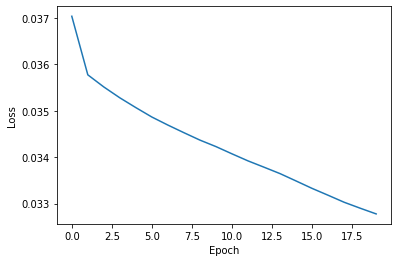

In [20]:
EPOCHS_TO_TRAIN = 20
train(network=net, 
      train_dataset=data, 
      epochs=EPOCHS_TO_TRAIN, 
      criterion=nn.CrossEntropyLoss(), 
      optimizer=optim.SGD(net.parameters(), lr=0.01))

## Test

In [21]:
def test_multiple(network, test_dataset, dividing_criterion):
    domik_x = []
    domik_y = []
    nedomik_x = []
    nedomik_y = []

    correct = 0
    total = 0

    with torch.no_grad():
        for sample in test_dataset:
            inp, target = sample
            output = network(inp)
            _, output = torch.max(output, 0)
            total += 1
            correct += (dividing_criterion(output) == dividing_criterion(target))

            # dividing dataset for plotting
            if dividing_criterion(output):
                
                domik_x.append(inp[0])
                domik_y.append(inp[1])
            else: 
                nedomik_x.append(inp[0])
                nedomik_y.append(inp[1])
    
    plt.figure(figsize=(20,5))
    plt.subplot(121)
    test_dataset.show()
    plt.subplot(122)
    plt.plot(domik_x, domik_y, '.', nedomik_x, nedomik_y, '.')

    print(f'Accuracy of the network on the {total} test samples: {100 * correct / total}')

25 эпох 0.1  
20 эпох 0.01

Accuracy of the network on the 25000 test samples: 99.376


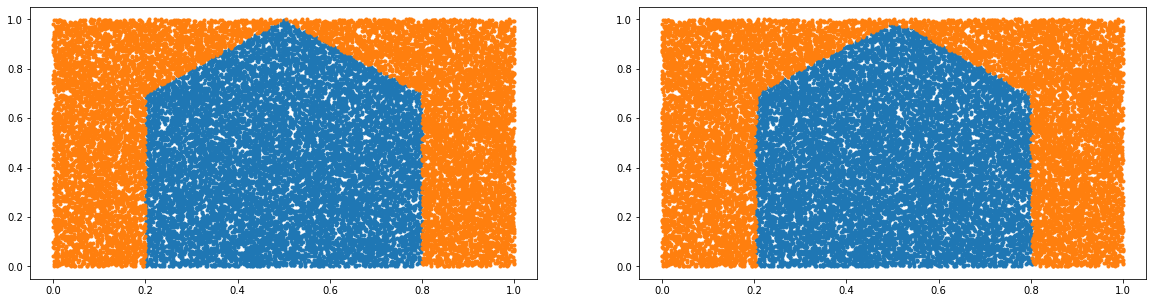

In [22]:
test_dataset = MultiClassDomikDataset(DATASET_SIZE*5)
test_multiple(network=net, test_dataset=test_dataset, dividing_criterion=lambda s: 1 if s > 0.5 else 0)

# Domik with window dataset

In [23]:
class WindowedDomikDataset(DomikDataset):
    def __init__(self, dataset_size, noise=0.0):
        super().__init__(dataset_size, noise)
        
    def _window(self, point, width=0.3, height=0.3, x=0.5, y='middle'):
        if y == 'middle':
            y = self.house_height / 2
        is_window = x - width / 2 <= point[0] <= x + width / 2 and \
            y - height / 2 <= point[1] <= y + height / 2
        return is_window
    
    def _generate(self, size, noise):
        points, targets = super()._generate(size, noise)
        for i, point in enumerate(points):
            if self._window(point):
                targets[i] = torch.tensor([0.], device=device)
        return points, targets

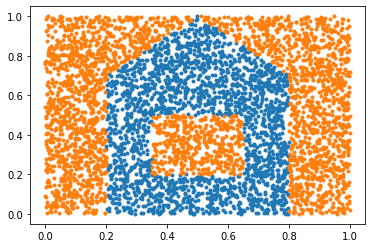

In [24]:
DATASET_SIZE = 5000
domik = WindowedDomikDataset(DATASET_SIZE)

# plotting
domik.show()

## Net

In [25]:
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(2, 60)
        self.fc2 = nn.Linear(60, 40)
        self.fc3 = nn.Linear(40, 1)

    def forward(self, x):
        x = F.leaky_relu(self.fc1(x))
        x = F.leaky_relu(self.fc2(x))
        x = F.leaky_relu(self.fc3(x))
        return x

net = Net().float().to(device)
print(net)

Net(
  (fc1): Linear(in_features=2, out_features=60, bias=True)
  (fc2): Linear(in_features=60, out_features=40, bias=True)
  (fc3): Linear(in_features=40, out_features=1, bias=True)
)


## Train

Epoch        0 Loss: 0.011574214918967528
Epoch        1 Loss: 0.011560541893882205
Epoch        2 Loss: 0.011578571228698655
Epoch        3 Loss: 0.011535489782814557
Epoch        4 Loss: 0.011393590045271004
Epoch        5 Loss: 0.01150688524567776
Epoch        6 Loss: 0.011332658746656352
Epoch        7 Loss: 0.011296707471591757
Epoch        8 Loss: 0.011284769508812206
Epoch        9 Loss: 0.011418721513891686
Epoch       10 Loss: 0.01128603470305548
Epoch       11 Loss: 0.011532404696300182
Epoch       12 Loss: 0.011442491114953105
Epoch       13 Loss: 0.011315164752963033
Epoch       14 Loss: 0.011300025171561635
Epoch       15 Loss: 0.011115154912047428
Epoch       16 Loss: 0.01125350646501572
Epoch       17 Loss: 0.011105303764375274
Epoch       18 Loss: 0.011132127860859703
Epoch       19 Loss: 0.011101683838626756
Epoch       20 Loss: 0.01107272534759432
Epoch       21 Loss: 0.011071600995442313
Epoch       22 Loss: 0.010959220358899173
Epoch       23 Loss: 0.010960352885894

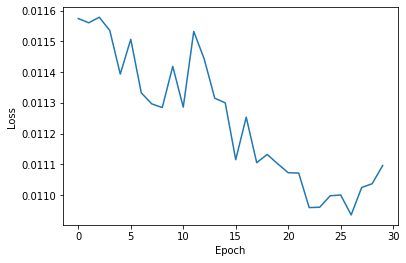

In [32]:
EPOCHS_TO_TRAIN = 30
train(network=net, 
      train_dataset=domik, 
      epochs=EPOCHS_TO_TRAIN, 
      criterion=nn.MSELoss(), 
      optimizer=optim.SGD(net.parameters(), lr=0.01))

25 эпох 0.1  
100 эпох 0.01

## Test

Accuracy of the network on the 25000 test samples: 98.388


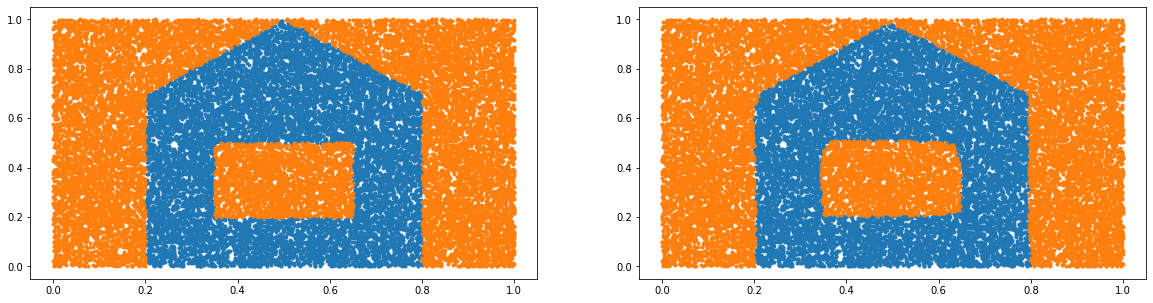

In [33]:
test_dataset = WindowedDomikDataset(DATASET_SIZE*5)
test(network=net, test_dataset=test_dataset, dividing_criterion=lambda s: 1 if s > 0.5 else 0)

# Homework

- [ ] Обучить обычный домик (Accuracy >98%). 1 балл
- [ ] Использовать для этого двухслойную сеть. 1 балл
- [ ] Обучить домик с многоклассовой классификацией (зa тавтологию извините) (Accuracy >98%). 1 балл
- [ ] Использовать для этого двухслойную сеть. 1 балл
- [ ] Обучить домик с окошком (Accuracy >98%). 1 балл
- [ ] Использовать для этого трехслойную сеть. 1 балл
- [ ] Обучить домик с дверью и двумя окошками (Accuracy >98%). 2 балла
- [ ] Использовать для этого трехслойную сеть. 2 балла

#### ВАЖНО! ВЫБОРКУ УВЕЛИЧИВАТЬ НЕЛЬЗЯ!

Домашку выполняем в этой тетрадке и заливаем на гит, инструкция - https://youtu.be/lPcEQJiHDfg. Форма для сдачи - https://forms.gle/RJtnENVjGP6H5oPn6 \
Удачи!

## Domik with door and 2 windows dataset

In [34]:
class DoorDomikDataset(WindowedDomikDataset):
    def __init__(self, dataset_size, noise=0.0):
        super().__init__(dataset_size, noise)
        
    def _door(self, point, width=0.2, height=0.5, x=0.5):
        y = height / 2
        is_door = x - width / 2 <= point[0] <= x + width / 2 and \
            y - height / 2 <= point[1] <= y + height / 2
        return is_door
    
    def _window(self, point, width=0.1, height=0.3, x=0.5, y='middle'):
        if y == 'middle':
            y = self.house_height / 2
        is_window = x - width / 2 <= point[0] <= x + width / 2 and \
            y - height / 2 <= point[1] <= y + height / 2
        return is_window
    
    def show(self):
        domik_x = []
        domik_y = []
        nedomik_x = []
        nedomik_y = []
        door_x = []
        door_y = []

        for sample in self:
            point, target = sample
            if target == 1:
                domik_x.append(point[0])
                domik_y.append(point[1])
            elif target == 0: 
                nedomik_x.append(point[0])
                nedomik_y.append(point[1])
            else:
                door_x.append(point[0])
                door_y.append(point[1])

        plt.plot(domik_x, domik_y, '.', nedomik_x, nedomik_y,'.', door_x, door_y, '.')
    def _generate(self, size, noise):
        points, targets = super()._generate(size, noise)
        for i, point in enumerate(points):
            if self._window(point, x=0.3):
                targets[i] = torch.tensor([0.], device=device)
            if self._window(point, x=0.7):
                targets[i] = torch.tensor([0.], device=device)
            if self._door(point):
                targets[i] = torch.tensor([2.], device=device)
                
            targets[i] = int(targets[i].item())
        return points, targets

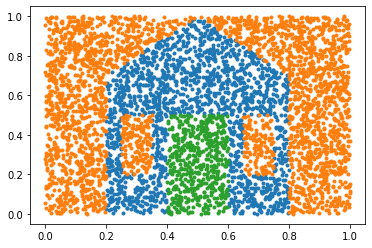

In [47]:
DATASET_SIZE = 5000
# generate dataset here
domik = DoorDomikDataset(DATASET_SIZE)

data = DataLoader(domik, batch_size=12)

# plotting
domik.show()

## Net

In [50]:
# create network here
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(2, 80)
        self.fc2 = nn.Linear(80, 50)
        self.fc3 = nn.Linear(50, 3)

    def forward(self, x):
        x = F.leaky_relu(self.fc1(x))
        x = F.leaky_relu(self.fc2(x))
        x = F.leaky_relu(self.fc3(x))
        return x

net = Net().float().to(device)
print(net)

Net(
  (fc1): Linear(in_features=2, out_features=80, bias=True)
  (fc2): Linear(in_features=80, out_features=50, bias=True)
  (fc3): Linear(in_features=50, out_features=3, bias=True)
)


## Train

Epoch        0 Loss: 0.056482963093045
Epoch        1 Loss: 0.056465586833643555
Epoch        2 Loss: 0.05646363537326265
Epoch        3 Loss: 0.05641524257697122
Epoch        4 Loss: 0.05625017940695591
Epoch        5 Loss: 0.056216686987228856
Epoch        6 Loss: 0.05615144726439344
Epoch        7 Loss: 0.0561584636212901
Epoch        8 Loss: 0.05614293438133044
Epoch        9 Loss: 0.05610591192665698
Epoch       10 Loss: 0.05613587458394199
Epoch       11 Loss: 0.05593045970409409
Epoch       12 Loss: 0.05604668926552871
Epoch       13 Loss: 0.05589086303771505
Epoch       14 Loss: 0.05599661860092728
Epoch       15 Loss: 0.05589609359813335
Epoch       16 Loss: 0.055848318478168846
Epoch       17 Loss: 0.05583588200145831
Epoch       18 Loss: 0.05571613646343379
Epoch       19 Loss: 0.05577333322986799
Epoch       20 Loss: 0.055827082467209375
Epoch       21 Loss: 0.05563246359206145
Epoch       22 Loss: 0.0558707644563232
Epoch       23 Loss: 0.05570439396893919
Epoch       24 L

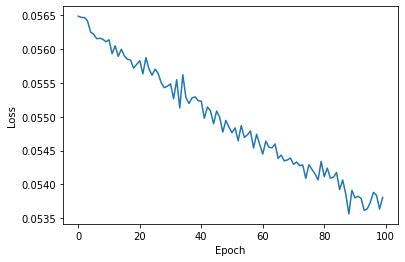

In [66]:
# train here
EPOCHS_TO_TRAIN = 100
train(network=net, 
      train_dataset=data, 
      epochs=EPOCHS_TO_TRAIN, 
      criterion=nn.CrossEntropyLoss(), 
      optimizer=optim.SGD(net.parameters(), lr=0.01))

## Test

In [52]:
def test_door_domik(network, test_dataset):
    domik_x = []
    domik_y = []
    nedomik_x = []
    nedomik_y = []
    door_x = []
    door_y = []

    correct = 0
    total = 0

    with torch.no_grad():
        for sample in test_dataset:
            inp, target = sample
            output = network(inp)
            _, output = torch.max(output, 0)
            total += 1
            correct += (output == target).sum().item()

            # dividing dataset for plotting
            if output == 1:
                domik_x.append(inp[0])
                domik_y.append(inp[1])
            elif output == 2:
                door_x.append(inp[0])
                door_y.append(inp[1])
            else: 
                nedomik_x.append(inp[0])
                nedomik_y.append(inp[1])
    
    plt.figure(figsize=(20,5))
    plt.subplot(121)
    test_dataset.show()
    plt.subplot(122)
    plt.plot(domik_x, domik_y, '.', nedomik_x, nedomik_y, '.', door_x, door_y, '.')

    print(f'Accuracy of the network on the {total} test samples: {100 * correct / total}')

30 0.1  
600 0.01

Accuracy of the network on the 25000 test samples: 98.32


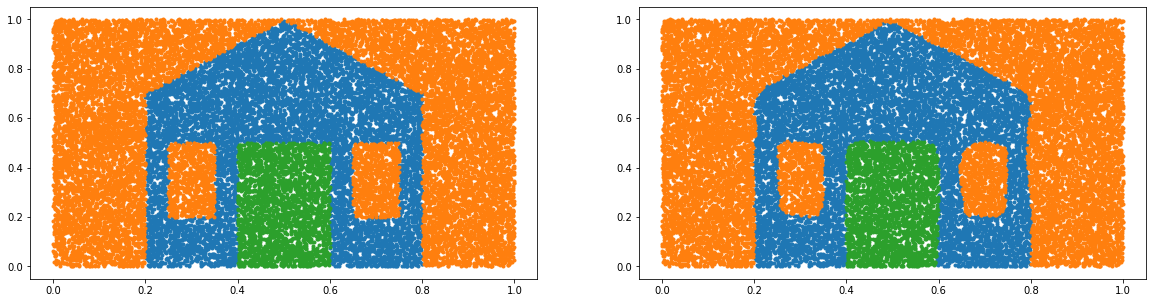

In [67]:
test_dataset = DoorDomikDataset(DATASET_SIZE*5)
test_door_domik(network=net, test_dataset=test_dataset)